### Problem : 
We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.

### Evaluation :
The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error). More on evaluation:

### Objective :
Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)
***

## Dataset & Library Loading

In [1]:
# Libraries

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud , STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer , PorterStemmer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
train_df = pd.read_csv("D:/Primary Things/Projects Main/NLP/Toxicity Classification/Dataset/train.csv")
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
test_df = pd.read_csv("D:/Primary Things/Projects Main/NLP/Toxicity Classification/Dataset/test.csv" , index_col = 'id' , engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [4]:
train_df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [5]:
train_df.shape

(1804874, 45)

In [6]:
train_df.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [8]:
train_df.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

##### No Null values for target & comment text.
##### Their are lot of null values present in columns asian,atheist etc. , but for the project we are only dealing with comment text so we will leave at is.

## Exploratory Data Analysis(EDA)

#### 1. Target Feature

<AxesSubplot:title={'center':'Target Value Distribution'}, xlabel='target', ylabel='Density'>

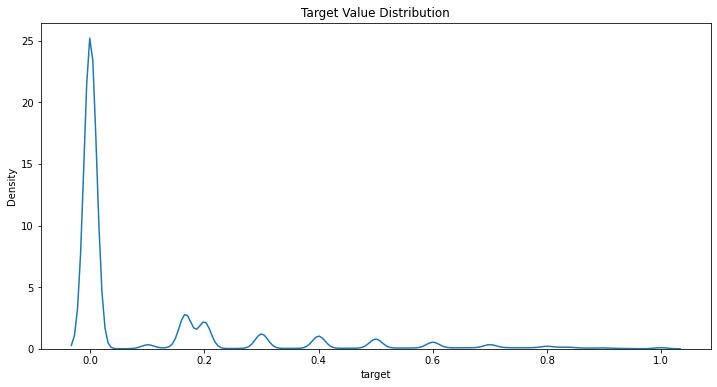

In [9]:
plt.figure(figsize = (12,6))
plt.title('Target Value Distribution')
sns.distplot(train_df['target'] , kde=True , hist=False , label='target')

##### The interpretation we obtain from the figure is that most the comments are actually non-toxic (>0.5) and only few of them are actually toxic. 

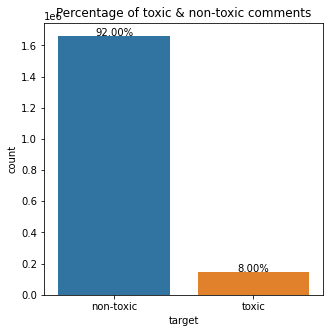

In [10]:
# Percentage of toxic and non-toxic comments

temp = train_df['target'].apply(lambda x:'non-toxic' if x <0.5 else 'toxic')

fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

cnt_plot = sns.countplot(temp)
cnt_plot.set_title('Percentage of toxic & non-toxic comments')

for p in ax.patches:
    height = p.get_height()
    
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

plt.show()

##### 92% of comments are non-toxic and only 8% are toxic. So data is imbalanced.

#### 2. Exploring Toxicity Features sub-types :
* severe_toxicity
* obscene
* threat
* insult
* identity_attack
* sexual_explicit

In [11]:
def features_plot(features,title,data):
    plt.figure(figsize = (14,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature] ,  kde = True , hist = False, bins=240 , label=feature)
    plt.legend()
    plt.xlabel('')
    plt.show()

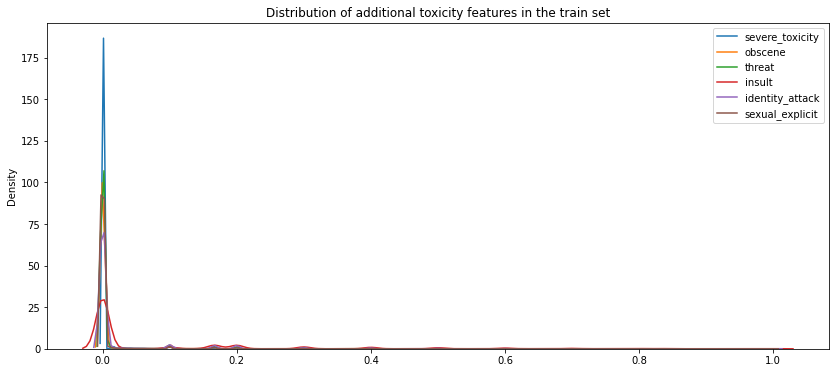

In [12]:
features = ['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']
features_plot(features,"Distribution of additional toxicity features in the train set",train_df)

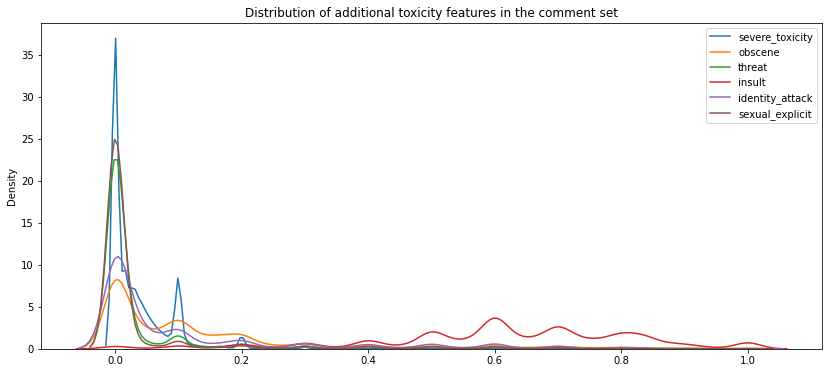

In [13]:
comment = train_df[train_df['target'] > 0.5]
features_plot(features,"Distribution of additional toxicity features in the comment set",comment)

##### We can see that for the toxic comment data we have more severe_toxicity(more insulting) comments than obscene comments

In [14]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def comment_nature(row):
    
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) 
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

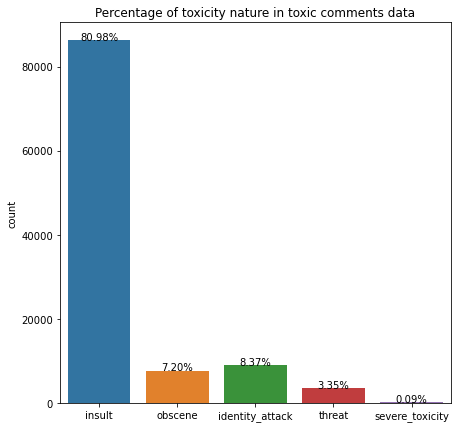

In [15]:
x = comment.apply(comment_nature, axis=1) 
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

##### In the dataset visualization depicts the total amount of toxic data present is 8%. By digging and doing analysis further we have found that in that 8% , 'insult' category amount 80%.

#### 3. Identity Attributes:
Sensitive topics:

* male
* female
* homosexual_gay_or_lesbian
* bisexual
* heterosexual
* christian
* jewish
* muslim
* black
* white
* asian
* latino

In [16]:
identity = train_df.dropna(axis=0 , how='any')

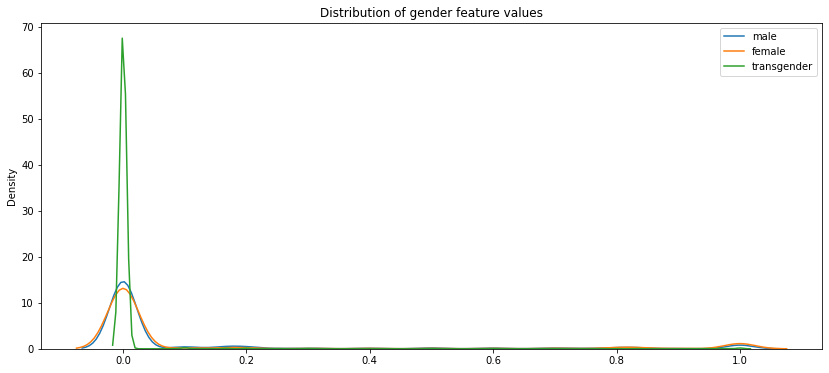

In [17]:
features = ['male', 'female', 'transgender']
features_plot(features, "Distribution of gender feature values", identity)

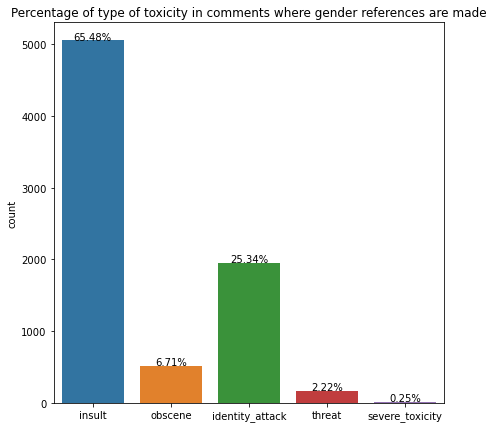

In [18]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

##### If the gender of the person is mentioned like male,transgender etc. then the toxic comments are generally insulting.

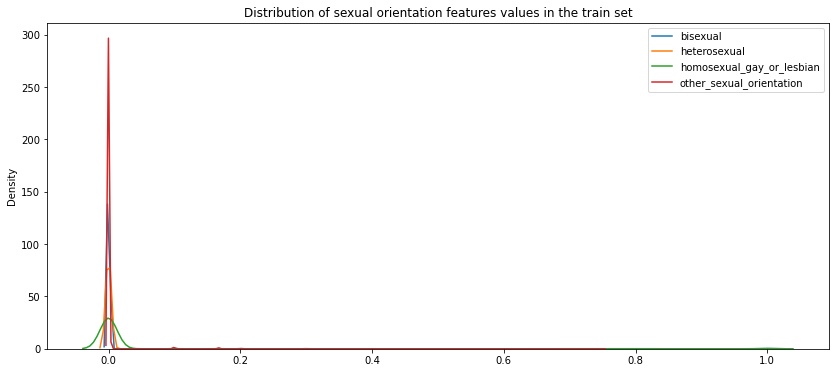

In [19]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
features_plot(features, "Distribution of sexual orientation features values in the train set", identity)

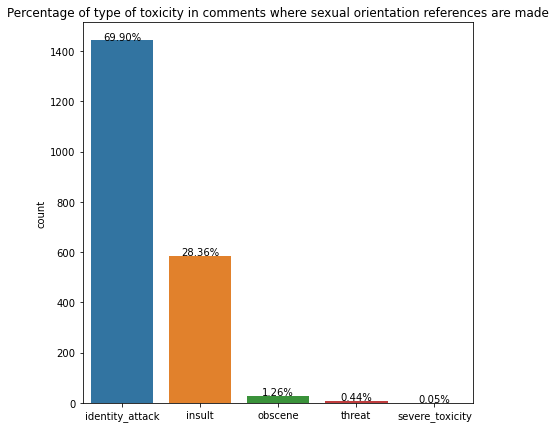

In [20]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

##### If the sexual orientation of the person is mention the most toxic are based on the identity basis.

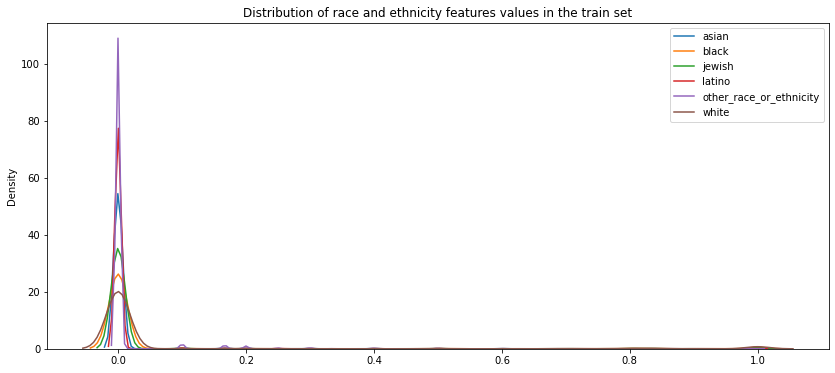

In [21]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
features_plot(features, "Distribution of race and ethnicity features values in the train set", identity)

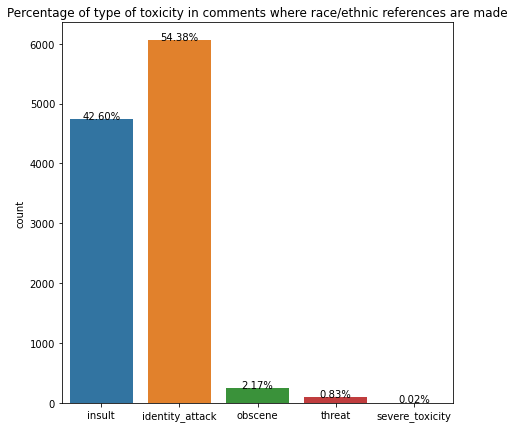

In [22]:
# Get data where race/ethnic references are made.

cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] >0.5) | (train_df['muslim'] > 0.5) | (train_df['christian'] > 0.5)
temp = train_df[cond] 
temp = temp[temp['target'] > 0.5] 

x = temp.apply(comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

##### The words like asian,muslim,black are mainly used for indentity attacks.

#### 4. Features generated by users feedback:
* funny
* sad
* wow
* likes
* disagree

In [23]:
def plot_count(feature, title, data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

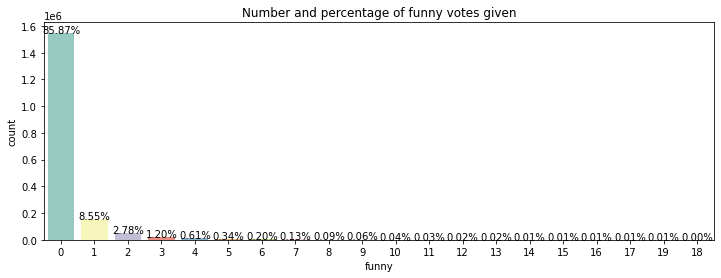

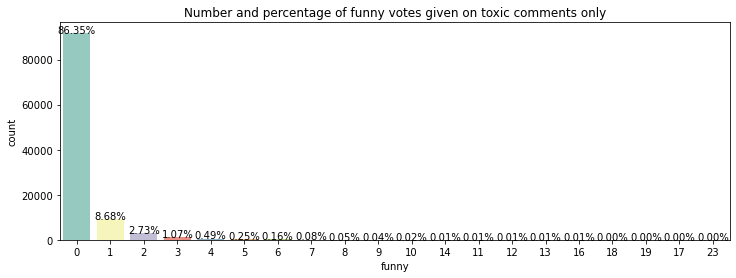

In [24]:
plot_count('funny','funny votes given', train_df)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5])

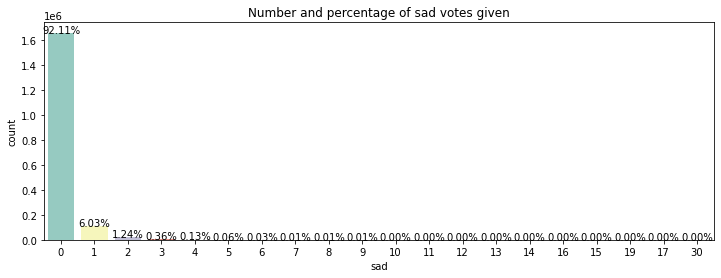

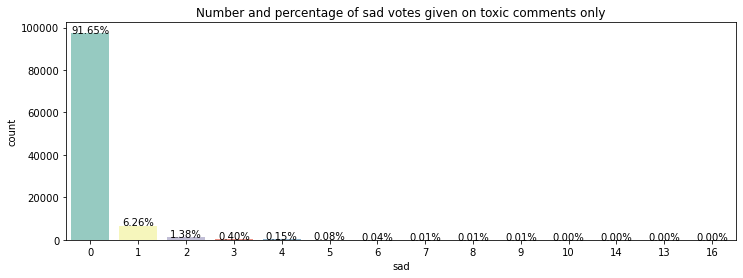

In [25]:
plot_count('sad','sad votes given', train_df)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5])

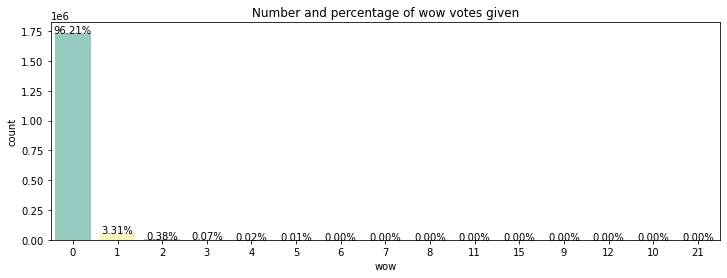

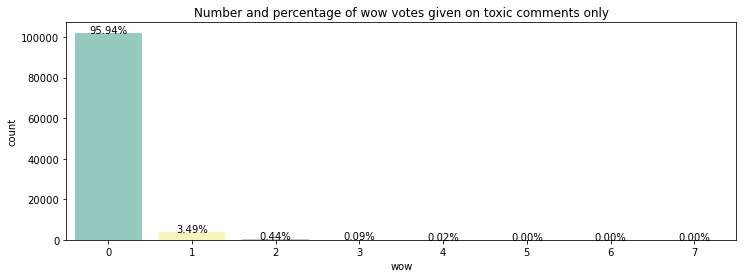

In [26]:
plot_count('wow','wow votes given', train_df)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5])

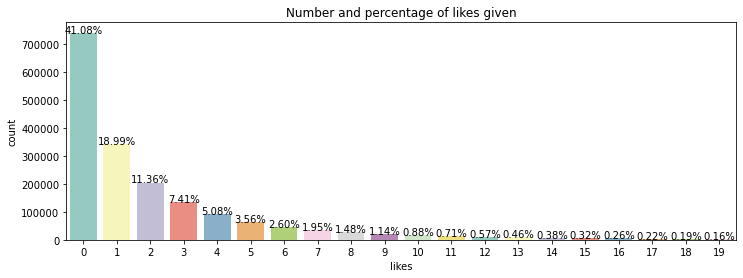

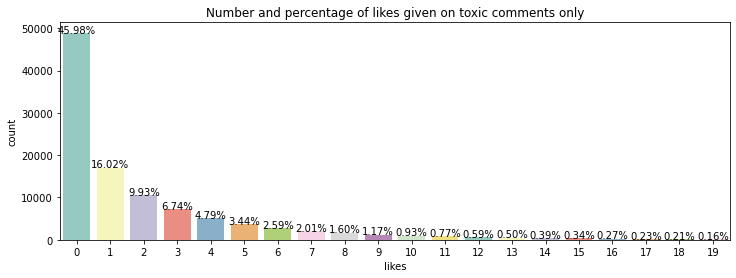

In [27]:
plot_count('likes','likes given', train_df)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5])

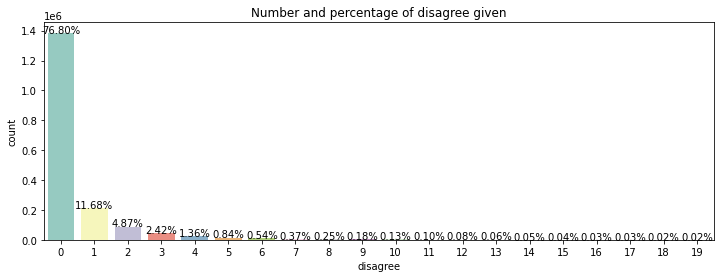

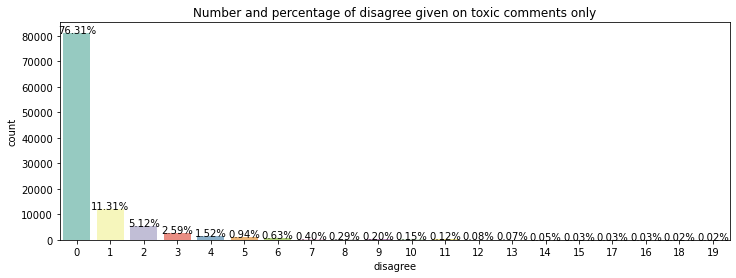

In [28]:
plot_count('disagree','disagree given', train_df)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5])

#### 5. Comments_text Feature:

In [29]:
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

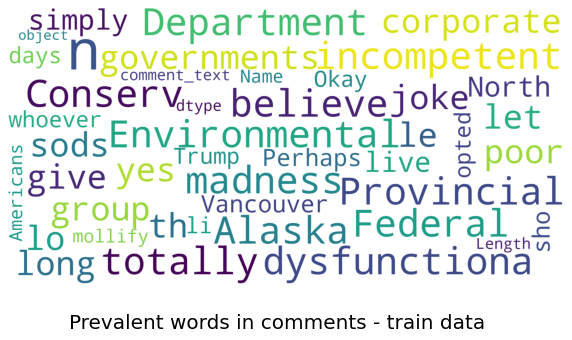

In [30]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

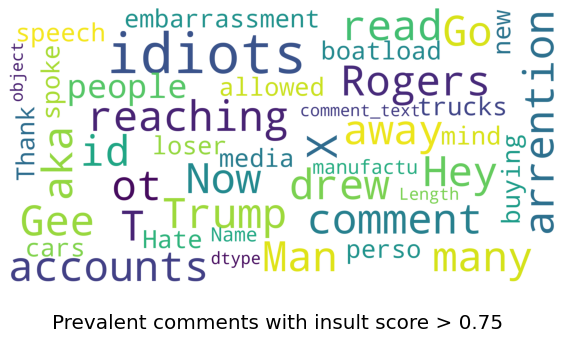

In [31]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

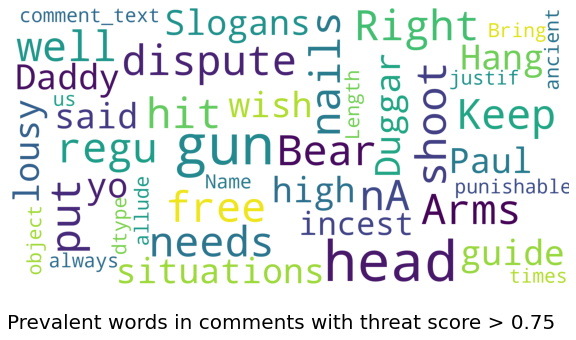

In [32]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

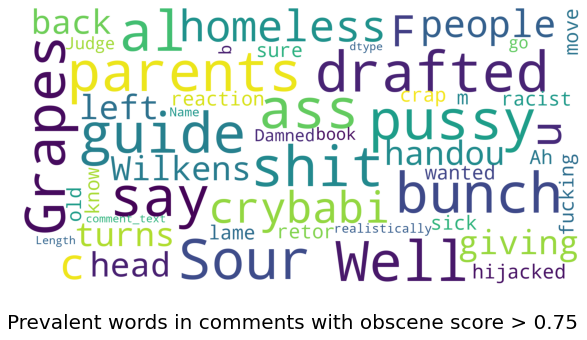

In [33]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

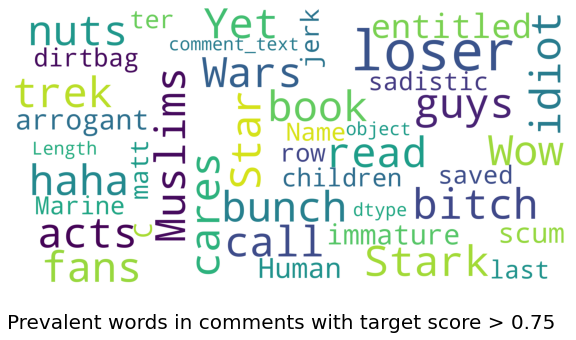

In [34]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

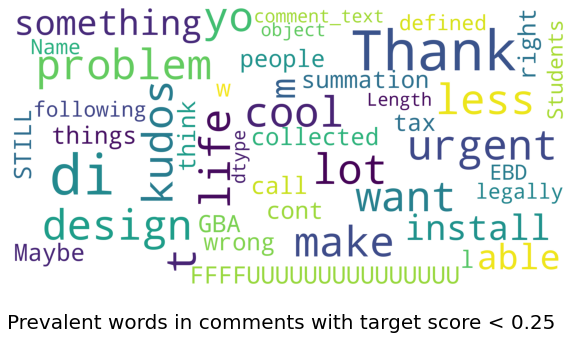

In [35]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

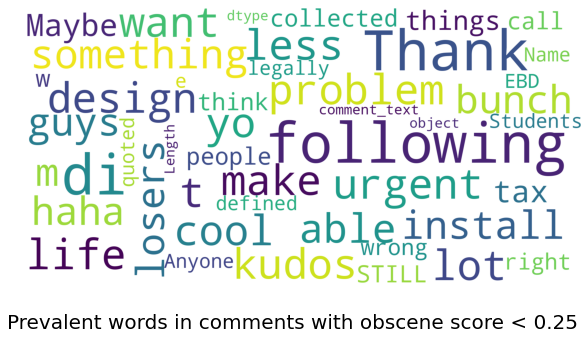

In [36]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

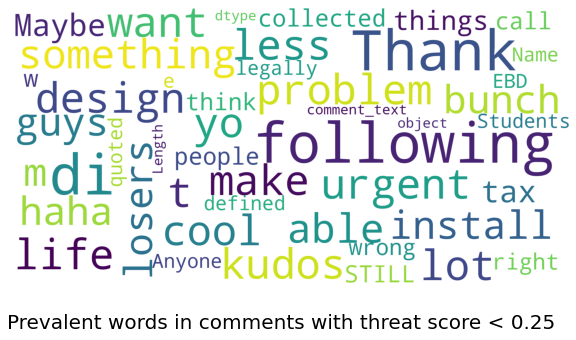

In [37]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

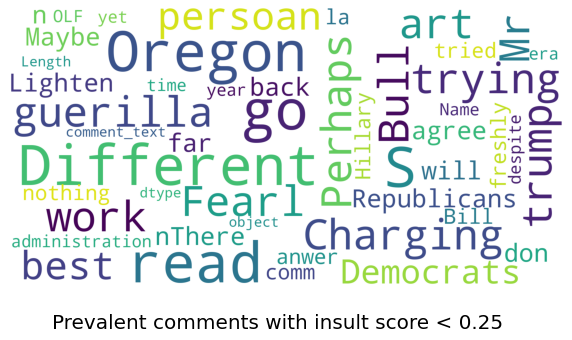

In [38]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

## Text Preprocessing & Train-Test-Split

In [ ]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() 
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) 
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [ ]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

In [ ]:
feature = train_df[['preprocessed_text']]
target = train_df[['target']]
X_train , X_cv , y_train , y_cv = train_test_split(feature , target)

In [ ]:
print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

In [39]:
#X_train.head()

In [40]:
#X_cv.head()

In [41]:
#y_train.head()

In [42]:
#y_cv.head()

#X_test = test_df[['preprocessed_text']]
#X_test.head()

X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Model

In [43]:
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

### 1. Bag of Words (BOW)

In [44]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


In [45]:
bow_train

<1353655x30000 sparse matrix of type '<class 'numpy.int64'>'
	with 36763634 stored elements in Compressed Sparse Row format>

#### a) SDGRegressor

##### a.1) Hyperparameter tuning 

In [46]:
alpha = [0.00001 , 0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100]
penalty = ['l1','l2']
xticks=[]
tr_errors = []
cv_errors = []
best_model = None
best_error = 100


for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        
        model = SGDRegressor(alpha=a , penalty=p)
        model.fit(bow_train,y_train)
        
        preds = model.predict(bow_train)
        err = mean_squared_error(y_train['target'],preds)
        tr_errors.append(err)
        print('Mean Squared Error on train set: ',err)
        
        preds = model.predict(bow_cv)
        err = mean_squared_error(y_cv['target'],preds)
        cv_errors.append(err)
        print('Mean Squared Error on cv set: ',err)
        
        if err < best_error:
            best_error = err
            best_model = model
            
        print('*'*50)


Mean Squared Error on train set:  0.6585897657752209
Mean Squared Error on cv set:  0.060842098019728084
**************************************************
Mean Squared Error on train set:  1.9433549330808424
Mean Squared Error on cv set:  0.14161590947031563
**************************************************
Mean Squared Error on train set:  0.024523133095371148
Mean Squared Error on cv set:  0.024375520378479572
**************************************************
Mean Squared Error on train set:  0.6588145707043638
Mean Squared Error on cv set:  0.06119469195646512
**************************************************
Mean Squared Error on train set:  0.03149409695800677
Mean Squared Error on cv set:  0.031407382377192185
**************************************************
Mean Squared Error on train set:  0.03489492408464505
Mean Squared Error on cv set:  0.027566642876956246
**************************************************
Mean Squared Error on train set:  0.038842759781137645
Mean Sq

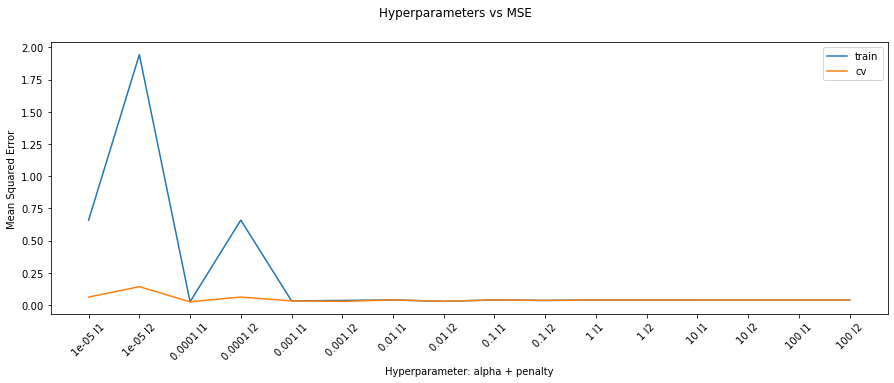

In [47]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [48]:
best_model.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### a.2) Feature Importance

In [49]:
feat_names = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.420385
stupid,0.336774
moron,0.295325
pathet,0.293401
crap,0.271712
hypocrit,0.261173
dumb,0.252162
ass,0.234032
clown,0.229184
damn,0.214120


In [50]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.016320
white hous,-0.011743
agre,-0.010893
point,-0.009590
http,-0.009453
https,-0.009355
great,-0.009198
year,-0.009125
stori,-0.008629
said,-0.008416


#### b) Decision Tree

##### b.1) Hyperparameter Tuning

In [51]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03310499773664262
Mean Squared Error on cv set:  0.03310989387778475
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.033104997736642605
Mean Squared Error on cv set:  0.033109893877784735
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.033107778882453316
Mean Squared Error on cv set:  0.0331094897876783
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03203616761888641
Mean Squared Error on cv set:  0.032016783956398995
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03203983694983062
Mean Squared Error on cv set:  0.03201305924472951
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.032070840210929825
Mean Squared Error on cv set:  0.032028583774960366
Depth- 7 Min Samples leaf-10 :
Mean Squared Error on train set:  0.031032979733262914
Mean Squared Error on cv set:  0.03101935314104521
Depth- 7 Min Samples leaf-100 :
Mean

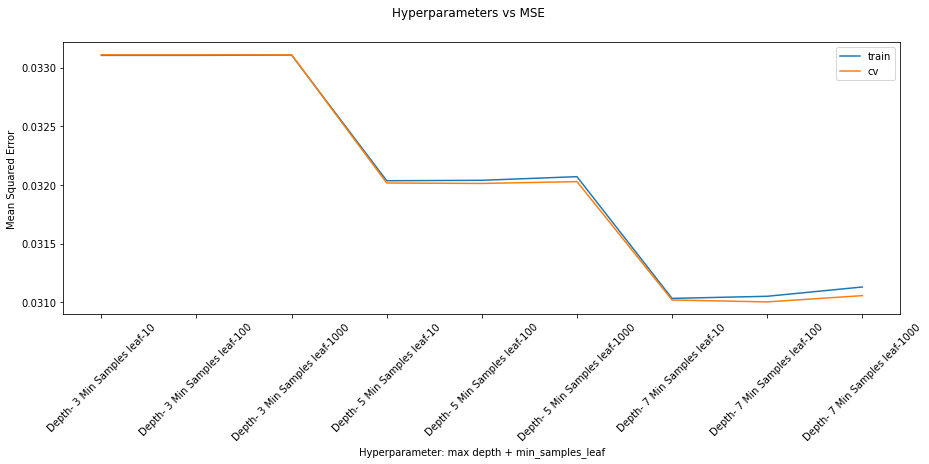

In [52]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [53]:

# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### b.2) Feature Importance

In [54]:

weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.394326
idiot,0.265676
pathet,0.070942
fool,0.067802
moron,0.062033
white,0.058903
hypocrit,0.055212
racist,0.005809
would,0.004043
year,0.003603


## 2. TF-IDF

In [55]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### a) SDGRegressor 

##### a.1) Hyperparameter Tunning

In [56]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.02530472085300316
Mean Squared Error on cv set:  0.025189955274343707
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.023943067698936973
Mean Squared Error on cv set:  0.023876322770199666
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.029755618548514103
Mean Squared Error on cv set:  0.02967124229560303
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.025055659435798048
Mean Squared Error on cv set:  0.02498956967753133
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03832047975003796
Mean Squared Error on cv set:  0.038296489351943824
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.03008940387999436
Mean Squared Error on cv set:  0.030038608928140507
****************************************

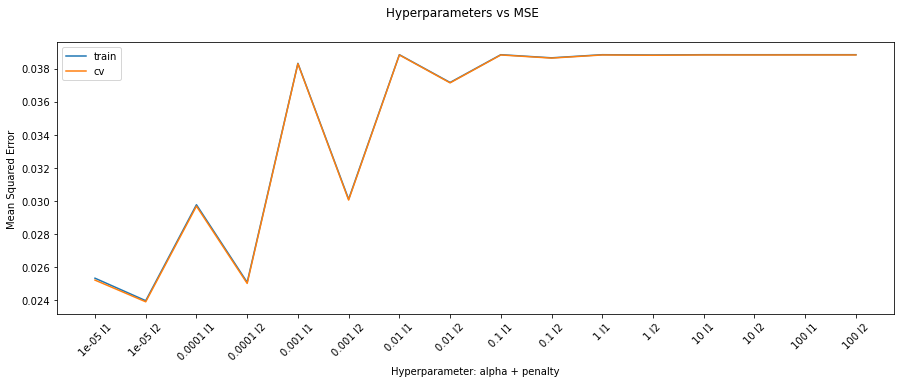

In [57]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### a.2) Feature Importance

In [58]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.562684
idiot,1.269405
fool,0.663199
ignor,0.604383
dumb,0.599061
pathet,0.596665
moron,0.568036
ridicul,0.556443
loser,0.555335
liar,0.523593


In [59]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.093253
interest,-0.085719
stori,-0.077682
agre,-0.077199
may,-0.074359
great,-0.073936
good,-0.069724
differ,-0.068896
new,-0.068540
work,-0.066471


#### b) Decision Tree

##### b.1) Hyperparameter Tunning

In [60]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03290115802031387
Mean Squared Error on cv set:  0.032908495876335944
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03290115802031387
Mean Squared Error on cv set:  0.032908495876335944
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03290115802031387
Mean Squared Error on cv set:  0.032908495876335944
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03177323785839073
Mean Squared Error on cv set:  0.031746022592976195
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03177477729728644
Mean Squared Error on cv set:  0.03174611683496953
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tr

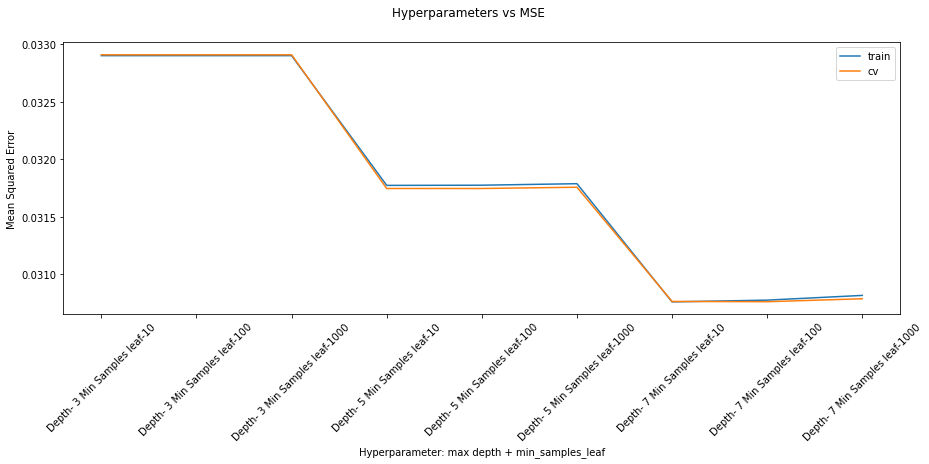

In [61]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### b.2) Feature Importance

In [62]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.403879
idiot,0.269922
pathet,0.072789
fool,0.071112
moron,0.062859
white,0.057683
dumb,0.054132
racist,0.005529
ignor,0.000699
trump,0.000537


### 1. BagOfWords:
- SGDRegressor:
Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2

Train MSE Loss: 0.02281
CV MSE Loss: 0.02326


- Decision Tree:
Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
 
 Train MSE Loss: 0.0310
 CV MSE Loss: 0.03128
### 2. TFIDF:
- SGDRegressor:
Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2

Train MSE Loss: 0.02556
CV MSE Loss: 0.02584

- Decision Tree:
Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100

Train MSE Loss: 0.03073
CV MSE Loss: 0.03122